In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.ai.vision.imageanalysis.models import VisualFeatures

from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [2]:
from dotenv import load_dotenv
import os

# Încarcă variabilele de mediu din fișierul .env
load_dotenv()

True

In [3]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [4]:
def getFrameForBikeImage(imagePath):
    bike_frame = [0,0,0,0]
    img = open(imagePath, "rb")
    result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
    for ob in result.objects:
        if (ob.object_property == "bicycle"):
            bike_frame = [ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h]
    return bike_frame

## Problema 1

In [5]:
file = open('ground_truth.csv')
lines = file.readlines()

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0

for line in lines:
    line = line.removesuffix('\n')
    tokens = line.split(',')
    imagePath = tokens[0]
    groundTruthFrame = [int(coord) for coord in tokens[1:]]
    bikeFrame = getFrameForBikeImage(imagePath)

    if groundTruthFrame == [0,0,0,0]:
        if bikeFrame == [0,0,0,0]:
            trueNegative += 1
        else:
            falsePositive += 1
    else:
        if bikeFrame == [0,0,0,0]:
            falseNegative += 1
        else:
            truePositive += 1

accuracy = (truePositive + trueNegative) / (truePositive + trueNegative + falsePositive + falseNegative)
precision = truePositive / (truePositive + falsePositive)
recall = truePositive / (truePositive + falseNegative)

print("Accuracy: {}\nPrecision: {}\nRecall: {}\n".format(accuracy,precision,recall))

Accuracy: 0.9
Precision: 1.0
Recall: 0.8



## Problema 2

<b><font color='green'>Green box</font></b> represents the frame that the program identifies<br><br>
<b><font color='red'>Red box</font></b> represents the ground truth

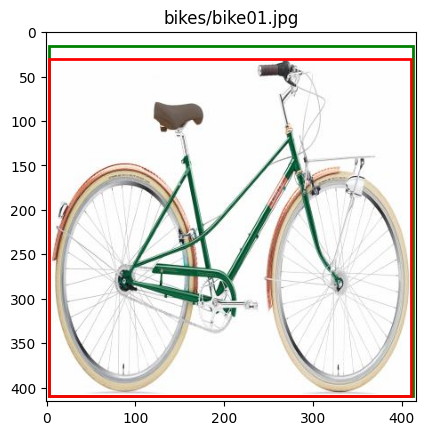

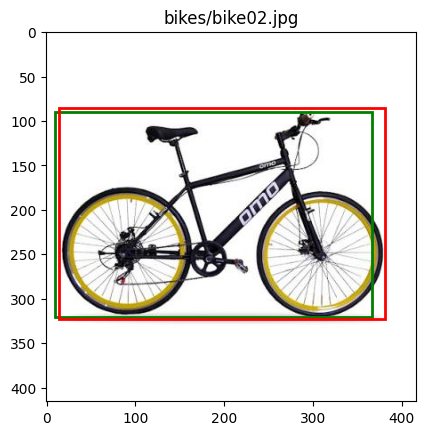

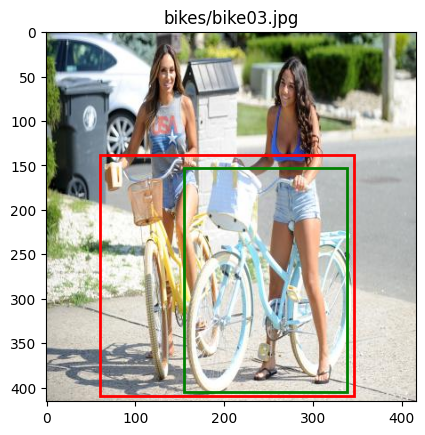

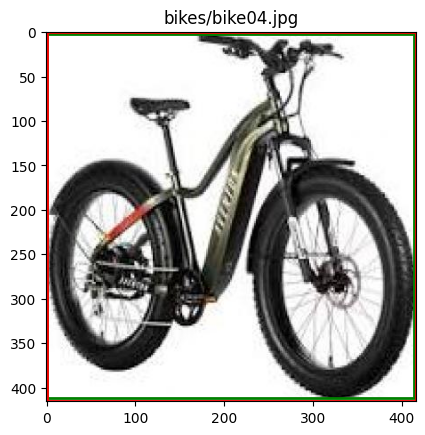

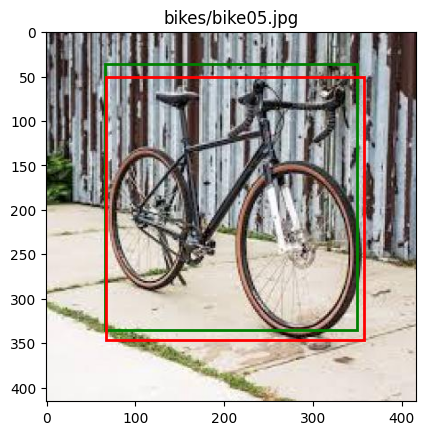

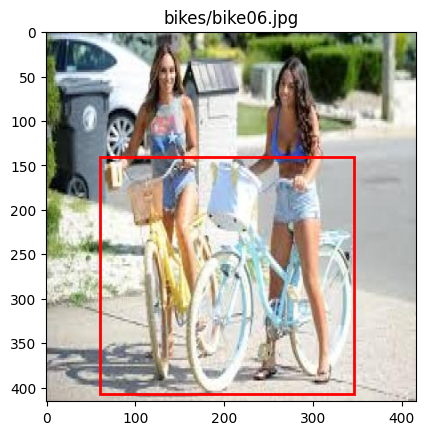

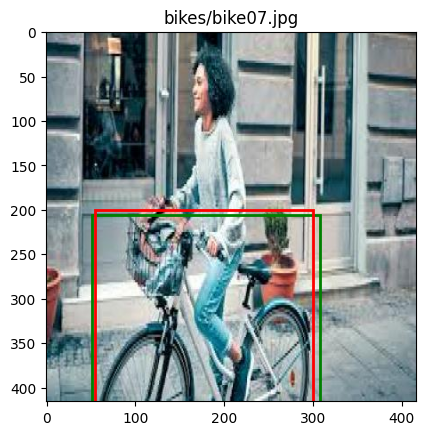

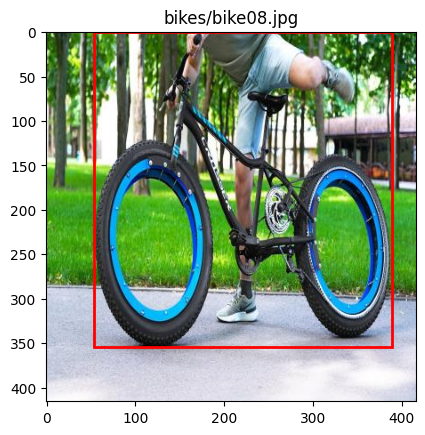

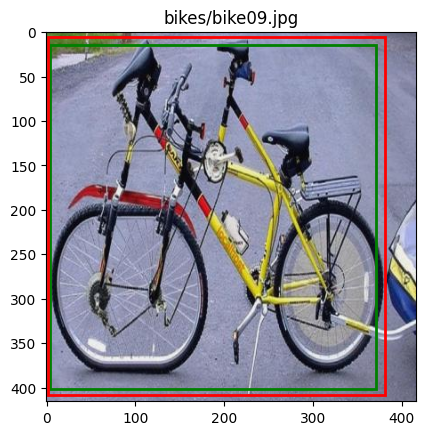

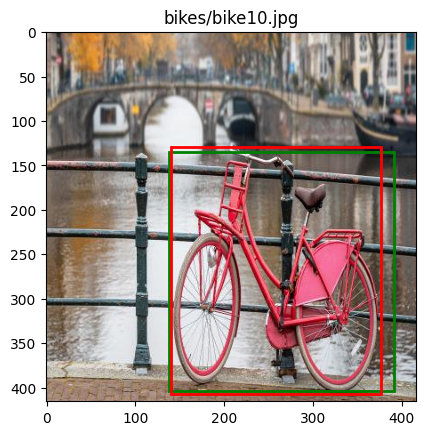

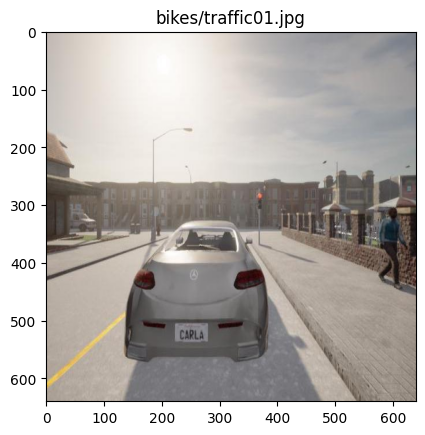

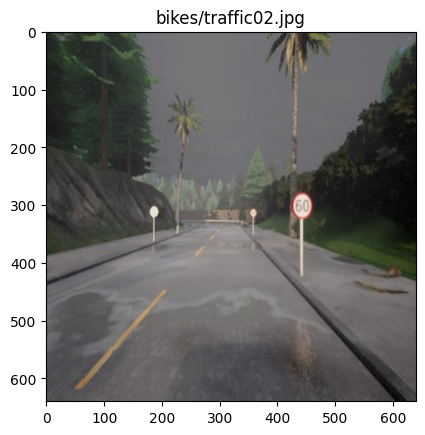

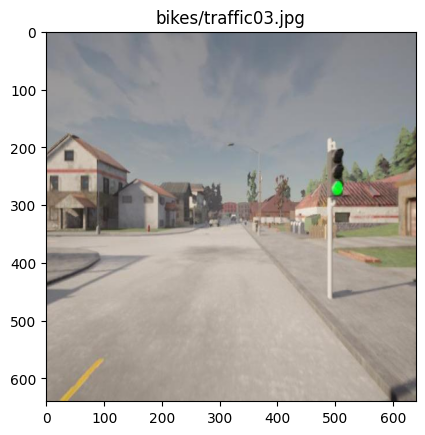

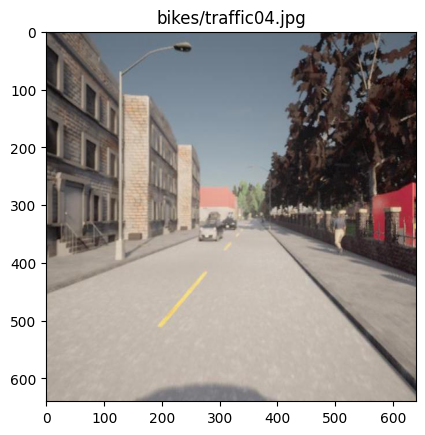

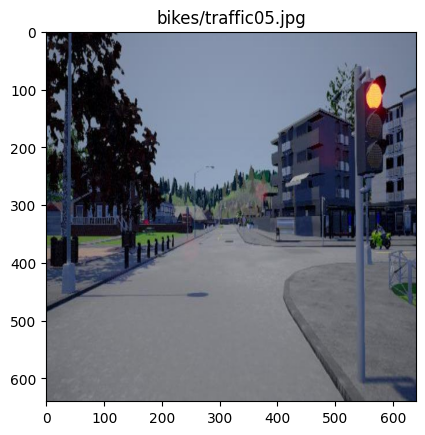

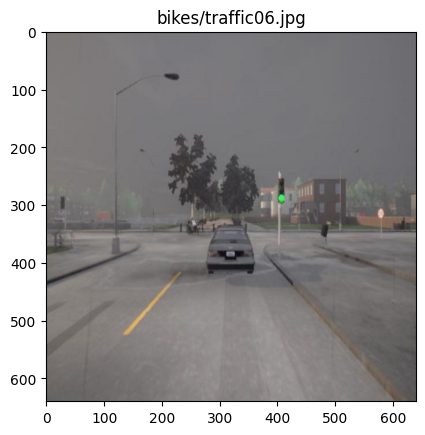

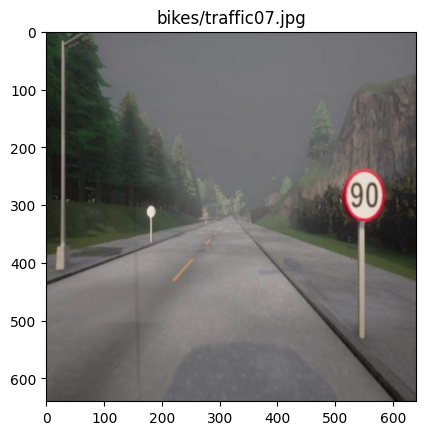

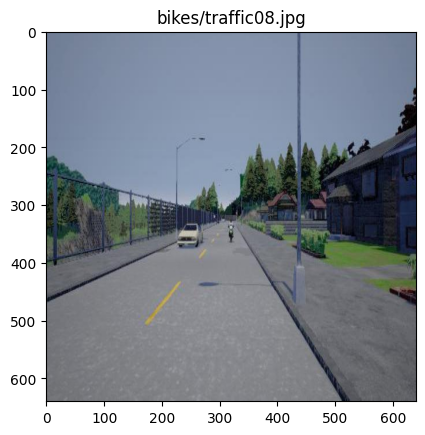

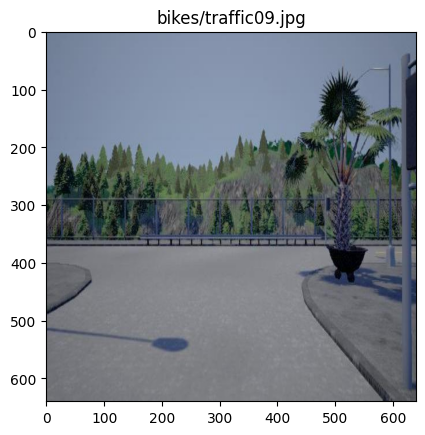

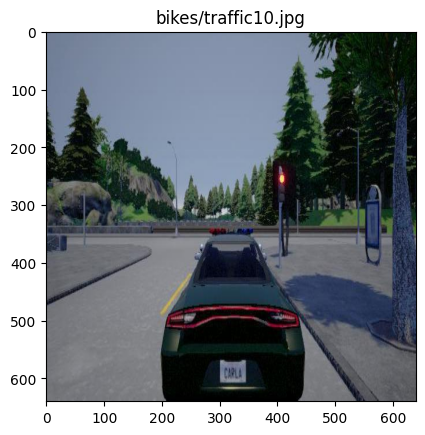

In [6]:
file = open('ground_truth.csv')
lines = file.readlines()

for line in lines:
    line = line.removesuffix('\n')
    tokens = line.split(',')
    imagePath = tokens[0]
    gorundTruthFrame = [int(coord) for coord in tokens[1:]]
    bikeFrame = getFrameForBikeImage(imagePath)

    fig,axes = plt.subplots()
    im = Image.open(imagePath)
    fig = plt.imshow(im)
    axes.add_patch(plt.Rectangle(xy = (bikeFrame[0], bikeFrame[1]), width = bikeFrame[2]-bikeFrame[0], height = bikeFrame[3]-bikeFrame[1], fill = False, color = "green", linewidth = 2))
    axes.add_patch(plt.Rectangle(xy = (gorundTruthFrame[0], gorundTruthFrame[1]), width = gorundTruthFrame[2]-gorundTruthFrame[0], height = gorundTruthFrame[3]-gorundTruthFrame[1], fill = False, color = "red", linewidth = 2))
    axes.set_title(imagePath)
plt.show()

In [ ]:
def intersection(patrat1, patrat2):
    topLeft1, bottomRigth1 = patrat1
    topLeft2, bottomRigth2 = patrat2

    xTopLeft1,yTopLeft1 = topLeft1
    xBottomRigth1,yBottomRigth1 = bottomRigth1
    xTopLeft2,yTopLeft2 = topLeft2
    xBottomRigth2,yBottomRigth2 = bottomRigth2

    topLeftIntersection = (max(xTopLeft1,xTopLeft2), max(yTopLeft1,yTopLeft2))
    bottomRigthIntersection = (min(xBottomRigth1,xBottomRigth2), min(yBottomRigth1,yBottomRigth2))

    return topLeftIntersection, bottomRigthIntersection

def Aria(patrat):
    topLeft, bottomRight = patrat
    xTopLeft, yTopLeft = topLeft
    xBottomRight, yBottomRight = bottomRight
    return (xBottomRight - xTopLeft) * (yBottomRight - yTopLeft)

In [ ]:
def intersectionOverUnion(patrat1, patrat2):
    if patrat1[0][0] == 0 and patrat1[0][1] == 0 and patrat1[1][0] == 0 and patrat1[1][0] == 0:
        if patrat2[0][0] == 0 and patrat2[0][1] == 0 and patrat2[1][0] == 0 and patrat2[1][1] == 0:
            return 1
        else:
            return 0
    topLeftIntersection, bottomRightIntersection = intersection(patrat1,patrat2)
    ariaPatrat1 = Aria(patrat1)
    ariaPatrat2 = Aria(patrat2)
    ariaIntersectie = Aria((topLeftIntersection, bottomRightIntersection))
    unionArea = ariaPatrat1 + ariaPatrat2 - ariaIntersectie

    return ariaIntersectie / unionArea

In [ ]:
file = open('ground_truth.csv')
lines = file.readlines()

for line in lines:
    line = line.removesuffix('\n')
    tokens = line.split(',')
    imagePath = tokens[0]
    groundTruthFrame = [int(coord) for coord in tokens[1:]]
    bikeFrame = getFrameForBikeImage(imagePath)

    patratGroundTruth = ((groundTruthFrame[0],groundTruthFrame[1]),(groundTruthFrame[2],groundTruthFrame[3]))
    patratGenerated = ((bikeFrame[0],bikeFrame[1]),(bikeFrame[2],bikeFrame[3]))

    print("Intersection over Union for image {}: {}".format(imagePath,intersectionOverUnion(patratGroundTruth,patratGenerated)))
    

Intersection over Union for image bikes/bike01.jpg: 0.9597507850024202
Intersection over Union for image bikes/bike02.jpg: 0.9187692794431701
Intersection over Union for image bikes/bike03.jpg: 0.5928116001645414
Intersection over Union for image bikes/bike04.jpg: 0.9832020389249305
Intersection over Union for image bikes/bike05.jpg: 0.8921376003196909


Intersection over Union for image bikes/bike06.jpg: 0.12359848150437008
Intersection over Union for image bikes/bike07.jpg: 0.93171734660751
Intersection over Union for image bikes/bike08.jpg: 0.0
Intersection over Union for image bikes/bike09.jpg: 0.9322953835678323
Intersection over Union for image bikes/bike10.jpg: 0.9045753124064918
Intersection over Union for image bikes/traffic01.jpg: 1
Intersection over Union for image bikes/traffic02.jpg: 1
Intersection over Union for image bikes/traffic03.jpg: 1
Intersection over Union for image bikes/traffic04.jpg: 1
Intersection over Union for image bikes/traffic05.jpg: 1
Intersection over Union for image bikes/traffic06.jpg: 1
Intersection over Union for image bikes/traffic07.jpg: 1
Intersection over Union for image bikes/traffic08.jpg: 1
Intersection over Union for image bikes/traffic09.jpg: 1
Intersection over Union for image bikes/traffic10.jpg: 1


In [7]:
truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0

treshhold = 0.6

file = open('ground_truth.csv')
lines = file.readlines()

for line in lines:
    line = line.removesuffix('\n')
    tokens = line.split(',')
    imagePath = tokens[0]
    groundTruthFrame = [int(coord) for coord in tokens[1:]]
    bikeFrame = getFrameForBikeImage(imagePath)

    patratGroundTruth = ((groundTruthFrame[0],groundTruthFrame[1]),(groundTruthFrame[2],groundTruthFrame[3]))
    patratGenerated = ((bikeFrame[0],bikeFrame[1]),(bikeFrame[2],bikeFrame[3]))

    prob = intersectionOverUnion(patratGroundTruth,patratGenerated)

    if groundTruthFrame != [0,0,0,0]:
        if prob > treshhold:
            truePositive += 1
        else:
            falseNegative += 1
    else:
        if prob > treshhold:
            falsePositive += 1
        else:
            trueNegative += 1

accuracy = (truePositive + trueNegative) / (truePositive + trueNegative + falsePositive + falseNegative)
precision = truePositive / (truePositive + falsePositive)
recall = truePositive / (truePositive + falseNegative)

print("Accuracy: {}\nPrecision: {}\nRecall: {}\n".format(accuracy,precision,recall))


NameError: name 'intersectionOverUnion' is not defined

[[761, 364, 1669, 981], [1169, 370, 2433, 968]]


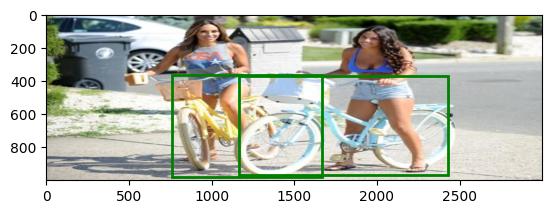

In [10]:
def getFrameForBikeImage2(imagePath):
    bike_frame = []
    img = open(imagePath, "rb")
    result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
    for ob in result.objects:
        if (ob.object_property == "bicycle"):
            bike_frame.append([ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h])
    return bike_frame

im = Image.open('bikes/bike03.jpg')

im = im.resize((3000,1000))
im.save('bikes/incercare.jpg')
fig,axes = plt.subplots()
fig = plt.imshow(im)
print(getFrameForBikeImage2('bikes/incercare.jpg'))
for bikeFrame in getFrameForBikeImage2('bikes/incercare.jpg'):
    
    axes.add_patch(plt.Rectangle(xy = (bikeFrame[0], bikeFrame[1]), width = bikeFrame[2]-bikeFrame[0], height = bikeFrame[3]-bikeFrame[1], fill = False, color = "green", linewidth = 2))

plt.show()

[[226, 365, 1434, 967], [1049, 382, 2497, 947]]


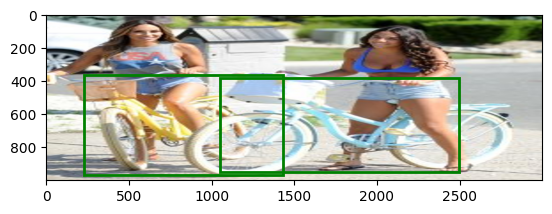

In [31]:
from PIL import ImageFilter
def getFrameForBikeImage2(imagePath):
    bike_frame = []
    img = open(imagePath, "rb")
    result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
    for ob in result.objects:
        if (ob.object_property == "bicycle"):
            bike_frame.append([ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h])
    return bike_frame

im = Image.open('bikes/bike03.jpg')
im = im.crop((80,0,360,im.height))
# im = im.filter(ImageFilter.DETAIL)
im = im.resize((3000,1000))
im.save('bikes/incercare.jpg')
fig,axes = plt.subplots()
fig = plt.imshow(im)
print(getFrameForBikeImage2('bikes/incercare.jpg'))
for bikeFrame in getFrameForBikeImage2('bikes/incercare.jpg'):
    axes.add_patch(plt.Rectangle(xy = (bikeFrame[0], bikeFrame[1]), width = bikeFrame[2]-bikeFrame[0], height = bikeFrame[3]-bikeFrame[1], fill = False, color = "green", linewidth = 2))
plt.show()